____
__Universite de Technologie de Troyes__<br/>
__Universidad Tecnologica Nacional Buenos Aires__<br/>
__Master OSS__<br/>
__Machine Learning & Pattern Recognition__<br/>
__Practice Sessions__<br/>
__Teacher: Martin Palazzo__<br/>
__source: https://github.com/martinepalazzo__<br/>
__Topic: Final Assessment__
____

# **Objectives for the assignment**
- make train-test-split (80% train , 20% test)
- within train set make dimension reduction with PCA, kPCA, Autoencoder from D = x.shape[1] features to P = [2,4,6]
- With an independent PCA after the reduction, visualize the reduced subspace in 2 dimensions and colour the samples with the labels.
- within train set perform classification with a SVM, KNN and Logistic Regression (check scikit learn toolkit). Select the best hyperparameters of the models by using cross-validation.
- Transform the test set with the dimension reduction learned in the first step. Then apply the learned classifier of the previous step and make classification. Determine which model is the best based on evaluation metrics.


# **Conditions**
- the assignment is individual and personal. Each student must do it by their own.
- The methodology and results obtained must be written in a 2 pages report (minimum) without counting figures. If the report has figures then it must have 3 pages (at least). 
#### **The report must include** 
- at least 3 cited papers.
- the following sections: Title, Abstract, Introduccion, Methods, Experiments, Discussion and Conclusions
- You are free to implement more methods

# Load dataset

In [1]:
# basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

#sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#keras
import keras
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras import models
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Dropout

In [2]:
# about the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
data = datasets.load_breast_cancer()

In [3]:
# get feature matrix and label vector

# get feature matrix
x = data.data

# get label vector
y = data.target

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


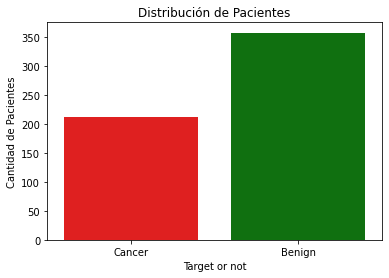

In [4]:
# visualize the label vector 
sns.countplot(y, palette=('red','green'))
plt.xlabel("Target or not")
plt.ylabel("Cantidad de Pacientes")
plt.title("Distribución de Pacientes")
plt.xticks(np.arange(2),('Cancer' ,'Benign'))
plt.show()


In [5]:
# get the shape of the X matrix
x.shape


(569, 30)

In [6]:
# Read the DataFrame, first using the feature data
df = pd.DataFrame(data.data, columns=data.feature_names)
# Add a target column, and fill it with the target data
df['target'] = data.target
# Show the first 20 rows
df.head(20)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.049040,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.013080,0.01860,0.013400,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.040060,0.03832,0.020580,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.074580,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.024610,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.013820,0.02254,0.010390,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.030290,0.02488,0.014480,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.035020,0.03553,0.012260,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.072170,0.07743,0.014320,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0


In [7]:
df_total = list(df.shape)[0]
df_count = list(df['target'].value_counts())

print("The Breast Cancer dataset has {} diagnosis samples, among them {} are benign and {} are malignant.".format(df_total, 
                                                                                 df_count[0], 
                                                                                 df_count[1]))

The Breast Cancer dataset has 569 diagnosis samples, among them 357 are benign and 212 are malignant.


In [8]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [9]:
## Split the data into training and test. Later on will split again train into train and validation

xtr, xte, ytr, yte = train_test_split(x,y, test_size = 0.2)

Text(33.0, 0.5, 'Samples')

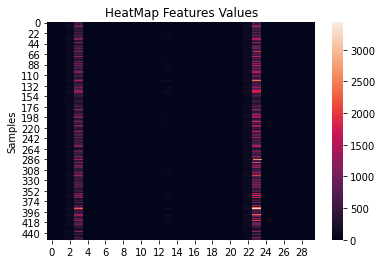

In [10]:
## Display the heatmap of all features without StandardScaler

ax= sns.heatmap(xtr)
ax.set_title('HeatMap Features Values')
ax.set_ylabel('Samples')

In [11]:
#High Variance, so will normalize the values

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
xtr = sc.fit_transform(xtr)
xte = sc.transform (xte)

Text(33.0, 0.5, 'Samples')

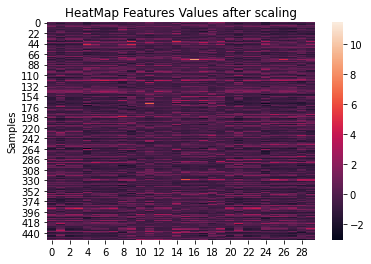

In [12]:
#Display again the heatman, after proccessing the information

ax=sns.heatmap(xtr)
ax.set_title('HeatMap Features Values after scaling')
ax.set_ylabel('Samples')

In [13]:
##AE Function defined in course

def ae_arch_0(encoding_dim, epochs, bachs, l1_reg, l2_reg, lrate, xtr, xte): 
    earlstop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
    
    ################### Optimizer ###################
    optim = keras.optimizers.Adam(lr=lrate)

    ################### MODEL ARCHITECTURE ###############
    
    # 00) INPUT
    inputdim = Input(shape=(xtr.shape[1],))
    
    # 01) DENSE LAYER
    encode_i = Dense(200, kernel_regularizer=regularizers.l2(l2_reg), activation = 'relu')(inputdim)
    
    # 02) BATCH NORM
    bn_i = BatchNormalization()(encode_i)
    
    # 03) DENSE LAYER
    encode_ii = Dense(100, activation = 'relu')(bn_i)

    latent = Dense(encoding_dim, kernel_regularizer = regularizers.l2(l2_reg), activation = 'relu')(encode_ii)

    # 04) DECODER
    decode_i = Dense(100, activation = 'relu')(latent)
    decode_ii = Dense(200,activation='relu')(latent)
    
    # 05) DECODER
    decode_iii = Dense(xtr.shape[1],activation='linear')(decode_ii)
    
    # 06) AUTOENCODER
    autoencoder = Model(inputdim, decode_iii)
    encoder = Model(inputdim, latent)
    
    #encoded_input5 = Input(shape=(encoding_dim5,))
    #decoder_layer5 = autoencoder5.layers[-3]
    #decoder5 = Model(x3, decoder_layer5(x3))

    autoencoder.summary()
    keras.utils.plot_model(autoencoder, show_shapes=True)
    compression_factor = float(np.shape(xtr)[1]) / encoding_dim
    print("Compression factor: %s" % compression_factor)
    
    ################## COMPILE AND FIT MODEL #############
    autoencoder.compile(optimizer=optim, loss='mse')
    autoencoder.fit(xtr, xtr,epochs=epochs, batch_size=bachs,  shuffle=True,  validation_data=(xte, xte), callbacks = [earlstop, rlrop])
    
    histval = autoencoder.history.history['val_loss']
    histtra = autoencoder.history.history['loss']
    
    return encoder, histtra, histval

In [14]:
## Dimensionality Reduction.

## PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xtr_pca_2 = pca.fit_transform(xtr)
xte_pca_2 = pca.transform(xte)
xtr_pca_df_2 = pd.DataFrame(data = xtr_pca_2
             , columns = ['feature_1', 'feature_2'])

pca = PCA(n_components=4)
xtr_pca_4 = pca.fit_transform(xtr)
xte_pca_4 = pca.transform(xte)
xtr_pca_df_4 = pd.DataFrame(data = xtr_pca_4
             , columns = ['feature_1', 'feature_2','feature_3', 'feature_4'])

pca = PCA(n_components=6)
xtr_pca_6 = pca.fit_transform(xtr)
xte_pca_6 = pca.transform(xte)
xtr_pca_df_6 = pd.DataFrame(data = xtr_pca_6
             , columns = ['feature_1', 'feature_2','feature_3','feature_4','feature_5','feature_6'])


## KPCA

from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=2, kernel='rbf')
xtr_kpca_2 = transformer.fit_transform(xtr)
xte_kpca_2 = transformer.transform(xte)
xtr_kpca_df_2 = pd.DataFrame(data = xtr_kpca_2
             , columns = ['feature_1', 'feature_2'])

transformer = KernelPCA(n_components=4, kernel='rbf')
xtr_kpca_4 = transformer.fit_transform(xtr)
xte_kpca_4 = transformer.transform(xte)
xtr_kpca_df_4 = pd.DataFrame(data = xtr_kpca_4
             , columns = ['feature_1', 'feature_2','feature_3', 'feature_4'])

transformer = KernelPCA(n_components=6, kernel='rbf')
xtr_kpca_6 = transformer.fit_transform(xtr)
xte_kpca_6 = transformer.transform(xte)
xtr_kpca_df_6 = pd.DataFrame(data = xtr_kpca_6
             , columns = ['feature_1', 'feature_2','feature_3','feature_4','feature_5','feature_6'])

##AE 

encoder_val_2, hist_tra, hist_val = ae_arch_0(2,50,32,0.001, 0.003, 0.0001, xtr, xte)
encoder_val_4, hist_tra, hist_val = ae_arch_0(4,50,32,0.001, 0.003, 0.0001, xtr, xte)
encoder_val_6, hist_tra, hist_val = ae_arch_0(6,50,32,0.001, 0.003, 0.0001, xtr, xte)


xtr_ae_2 = encoder_val_2.predict(xtr)
xte_ae_2 = encoder_val_2.predict(xte)
xtr_ae_4 = encoder_val_4.predict(xtr)
xte_ae_4= encoder_val_4.predict(xte)
xtr_ae_6 = encoder_val_6.predict(xtr)
xte_ae_6 = encoder_val_6.predict(xte)




Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               6200      
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_4 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_5 (Dense)              (None, 30)               

In [15]:
## For visualization i reduce all the previous transformations to a 2D latent space

pca = PCA(n_components=2)

#PCA to 2D
xtr_pca_2_2 = xtr_pca_2
xtr_pca_4_2 = pca.fit_transform(xtr_pca_4)
xtr_pca_6_2 = pca.fit_transform(xtr_pca_6)

#KPCA to 2D
xtr_kpca_2_2 = pca.fit_transform(xtr_kpca_2)
xtr_kpca_4_2 = pca.fit_transform(xtr_kpca_4)
xtr_kpca_6_2 = pca.fit_transform(xtr_kpca_6)


#AE to 2D

xtr_ae_2_2 = pca.fit_transform(xtr_ae_2)
xtr_ae_4_2 = pca.fit_transform(xtr_ae_4)
xtr_ae_6_2 = pca.fit_transform(xtr_ae_6)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

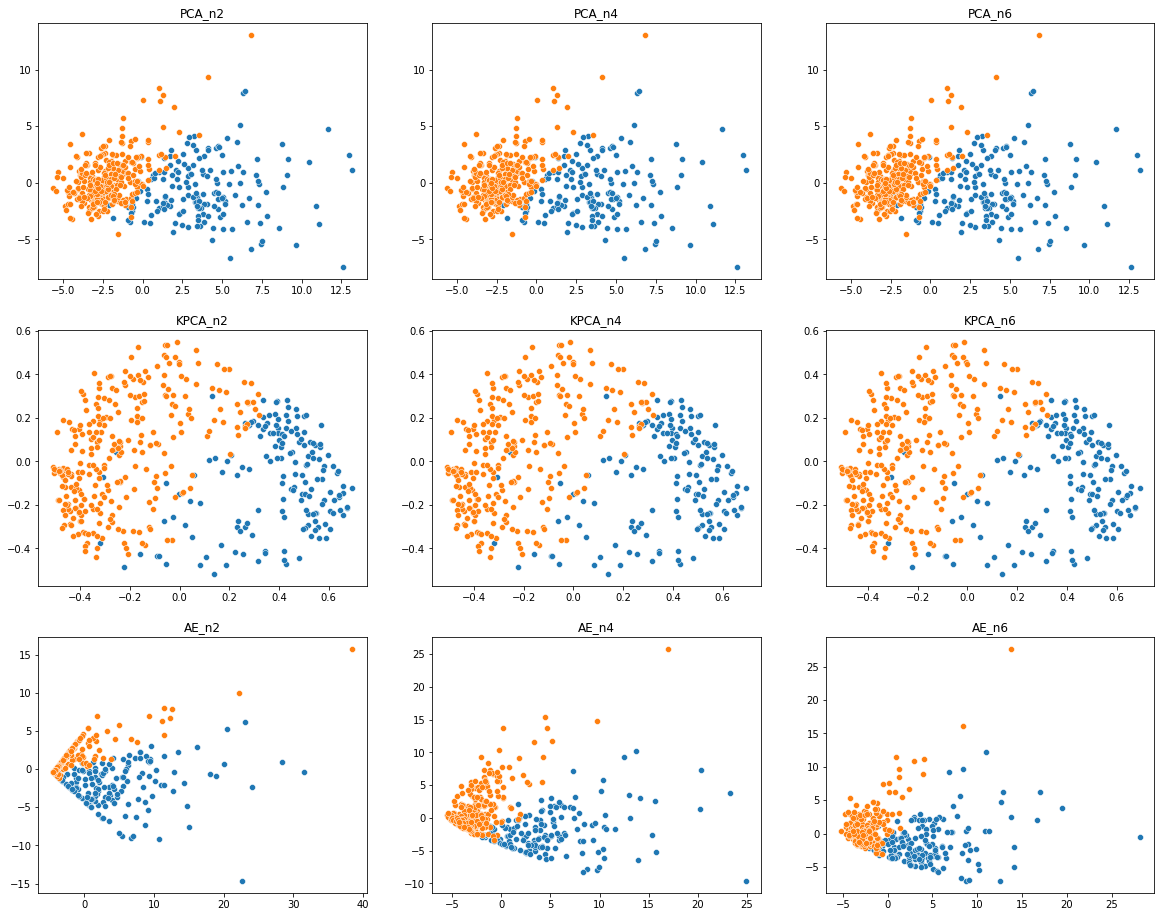

In [16]:
#Plot of all the visualizations.

f, ax = plt.subplots(3,3)
plt.subplots_adjust(wspace = 0.2, hspace = 0.2)


ax[0,0].figure.set_size_inches((20,16))

sns.scatterplot(xtr_pca_2_2[ytr.ravel() == 0,0], xtr_pca_2_2[ytr.ravel() == 0,1] ,ax= ax[0,0])
sns.scatterplot(xtr_pca_2_2[ytr.ravel() == 1,0], xtr_pca_2_2[ytr.ravel() == 1,1], ax= ax[0,0] )
ax[0,0].set_title("PCA_n2")

sns.scatterplot( xtr_pca_4_2[ytr == 0,0], xtr_pca_4_2[ytr == 0,1], ax= ax[0,1])
sns.scatterplot( xtr_pca_4_2[ytr == 1,0], xtr_pca_4_2[ytr == 1,1], ax= ax[0,1])
ax[0,1].set_title("PCA_n4")

sns.scatterplot(xtr_pca_6_2[ytr == 0,0],  xtr_pca_6_2[ytr == 0,1],ax= ax[0,2])
sns.scatterplot( xtr_pca_6_2[ytr == 1,0], xtr_pca_6_2[ytr == 1,1],ax= ax[0,2])
ax[0,2].set_title("PCA_n6")


sns.scatterplot(xtr_kpca_2_2[ytr == 0,0], xtr_kpca_2_2[ytr == 0,1],ax= ax[1,0])
sns.scatterplot( xtr_kpca_2_2[ytr == 1,0], xtr_kpca_2_2[ytr == 1,1],ax= ax[1,0])
ax[1,0].set_title("KPCA_n2")

sns.scatterplot(xtr_kpca_4_2[ytr == 0,0],xtr_kpca_4_2[ytr == 0,1],ax= ax[1,1])
sns.scatterplot(xtr_kpca_4_2[ytr == 1,0], xtr_kpca_4_2[ytr == 1,1],ax= ax[1,1])
ax[1,1].set_title("KPCA_n4")


sns.scatterplot(xtr_kpca_6_2[ytr == 0,0],  xtr_kpca_6_2[ytr == 0,1], ax= ax[1,2])
sns.scatterplot(xtr_kpca_6_2[ytr == 1,0], xtr_kpca_6_2[ytr == 1,1], ax= ax[1,2])
ax[1,2].set_title("KPCA_n6")


sns.scatterplot(xtr_ae_2_2[ytr == 0,0], xtr_ae_2_2[ytr == 0,1], ax= ax[2,0])
sns.scatterplot(xtr_ae_2_2[ytr == 1,0], xtr_ae_2_2[ytr == 1,1], ax= ax[2,0])
ax[2,0].set_title("AE_n2")

sns.scatterplot(xtr_ae_4_2[ytr == 0,0], xtr_ae_4_2[ytr == 0,1], ax= ax[2,1])
sns.scatterplot(xtr_ae_4_2[ytr == 1,0], xtr_ae_4_2[ytr == 1,1], ax= ax[2,1])
ax[2,1].set_title("AE_n4")

sns.scatterplot(xtr_ae_6_2[ytr == 0,0],  xtr_ae_6_2[ytr == 0,1], ax= ax[2,2])
sns.scatterplot(xtr_ae_6_2[ytr == 1,0],  xtr_ae_6_2[ytr == 1,1], ax= ax[2,2])
ax[2,2].set_title("AE_n6")

plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

lr=LogisticRegression()
knn=KNeighborsClassifier(n_neighbors=5)
svc=svm.SVC(kernel='linear')
#rf=RandomForestClassifier()
#gb=GradientBoostingClassifier()
#ex=ExtraTreesClassifier()

ensemble_clf=[lr, knn, svc] 

params1={'penalty': ['none', 'l1', 'l2', 'elasticnet'], 'C': [1,2,5,10]}
params2={'n_neighbors': [1,3,5,10,20], 'metric' : ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform','distance']}
params3={'kernel':('linear', 'rbf'), 'C':[1, 3, 5 ,10]}

parameters_list=[params1, params2, params3]

model_log=["_lr", "_knn", "_svc"]


result_pca_2=[]
result_pca_4=[]
result_pca_6=[]

result_kpca_2=[]
result_kpca_4=[]
result_kpca_6=[]

result_ae_2=[]
result_ae_4=[]
result_ae_6=[]


results=[result_pca_2,result_pca_4,result_pca_6,result_kpca_2,result_kpca_4,result_kpca_6]

for i in range(len(ensemble_clf)):
    Grid_pca_2=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                      n_jobs=-1, cv=5, verbose=1).fit(xtr_pca_2, ytr)
    Grid_pca_4=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                      n_jobs=-1, cv=5, verbose=1).fit(xtr_pca_4, ytr)
    Grid_pca_6=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                      n_jobs=-1, cv=5, verbose=1).fit(xtr_pca_6, ytr)
    
    Grid_kpca_2=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                      n_jobs=-1, cv=5, verbose=1).fit(xtr_kpca_2, ytr)
    Grid_kpca_4=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                      n_jobs=-1, cv=5, verbose=1).fit(xtr_kpca_4, ytr)
    Grid_kpca_6=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                      n_jobs=-1, cv=5, verbose=1).fit(xtr_kpca_6, ytr)
    
    Grid_ae_2=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                     n_jobs=-1, cv=5, verbose=1).fit(xtr_ae_2, ytr)
    Grid_ae_4=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                     n_jobs=-1, cv=5, verbose=1).fit(xtr_ae_4, ytr)
    Grid_ae_6=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                     n_jobs=-1, cv=5, verbose=1).fit(xtr_ae_6, ytr)
    
    result_pca_2.append\
        ({'classifier': Grid_pca_2.best_estimator_, 
          'best score': Grid_pca_2.best_score_, 
          'best params': Grid_pca_2.best_params_ })
    
    result_pca_4.append\
        ({'classifier': Grid_pca_4.best_estimator_, 
          'best score': Grid_pca_4.best_score_, 
          'best params': Grid_pca_4.best_params_ })
    
    result_pca_6.append\
        ({'classifier': Grid_pca_6.best_estimator_, 
          'best score': Grid_pca_6.best_score_, 
          'best params': Grid_pca_6.best_params_ })
    
    result_kpca_2.append\
        ({'classifier': Grid_kpca_2.best_estimator_, 
          'best score': Grid_kpca_2.best_score_, 
          'best params': Grid_kpca_2.best_params_ })
    
    result_kpca_4.append\
        ({'classifier': Grid_kpca_4.best_estimator_, 
          'best score': Grid_kpca_4.best_score_, 
          'best params': Grid_kpca_4.best_params_ })
    
    result_kpca_6.append\
        ({'classifier': Grid_kpca_6.best_estimator_, 
          'best score': Grid_kpca_6.best_score_, 
          'best params': Grid_kpca_6.best_params_ })
    
    result_ae_2.append\
        ({'classifier': Grid_ae_2.best_estimator_, 
          'best score': Grid_ae_2.best_score_, 
          'best params': Grid_ae_2.best_params_ })
    
    result_ae_4.append\
        ({'classifier': Grid_ae_4.best_estimator_, 
          'best score': Grid_ae_4.best_score_, 
          'best params': Grid_ae_4.best_params_ })
    
    result_ae_6.append\
        ({'classifier': Grid_ae_6.best_estimator_, 
          'best score': Grid_ae_6.best_score_, 
          'best params': Grid_ae_6.best_params_ })
    
    
        

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [18]:
print(result_pca_2)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9582417582417582, 'best params': {'C': 1, 'penalty': 'none'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='distance'), 'best score': 0.9428571428571428, 'best params': {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}}, {'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verb

In [19]:
print(result_pca_4)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9626373626373625, 'best params': {'C': 1, 'penalty': 'l2'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform'), 'best score': 0.9428571428571428, 'best params': {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}}, {'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=Fal

In [20]:
print(result_pca_6)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9670329670329672, 'best params': {'C': 1, 'penalty': 'l2'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'), 'best score': 0.9516483516483516, 'best params': {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}}, {'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=Fal

In [21]:
print(result_kpca_2)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9538461538461538, 'best params': {'C': 1, 'penalty': 'none'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance'), 'best score': 0.9428571428571428, 'best params': {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}}, {'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verb

In [22]:
print(result_kpca_4)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9472527472527472, 'best params': {'C': 1, 'penalty': 'none'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), 'best score': 0.9406593406593406, 'best params': {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}}, {'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=

In [23]:
print(result_kpca_6)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9670329670329669, 'best params': {'C': 1, 'penalty': 'none'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'), 'best score': 0.945054945054945, 'best params': {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}}, {'classifier': SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=

In [24]:
print(result_ae_2)

[{'classifier': LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9670329670329672, 'best params': {'C': 5, 'penalty': 'l2'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'), 'best score': 0.9626373626373625, 'best params': {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}}, {'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=Fals

In [25]:
print(result_ae_4)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.945054945054945, 'best params': {'C': 1, 'penalty': 'none'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='distance'), 'best score': 0.9384615384615385, 'best params': {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}}, {'classifier': SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbos

In [26]:
print(result_ae_6)

[{'classifier': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'best score': 0.9626373626373625, 'best params': {'C': 1, 'penalty': 'none'}}, {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'), 'best score': 0.9582417582417584, 'best params': {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}}, {'classifier': SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose

In [27]:
from sklearn.linear_model import LogisticRegression

#PCA
model_lr_1 = LogisticRegression(C=1 ,penalty= 'l2' )
model_lr_2 = LogisticRegression(C=1 ,penalty= 'none')
model_lr_3 = LogisticRegression(C=1 ,penalty= 'l2')

model_lr_1.fit(xtr_pca_2, ytr)
model_lr_2.fit(xtr_pca_4, ytr)
model_lr_3.fit(xtr_pca_6, ytr)

y_pred_model_lr_1 = model_lr_1.predict(xte_pca_2)
y_pred_model_lr_2 = model_lr_2.predict(xte_pca_4)
y_pred_model_lr_3 = model_lr_3.predict(xte_pca_6)

#KPCA
model_lr_4 = LogisticRegression(C= 1, penalty= 'none' )
model_lr_5 = LogisticRegression(C= 10, penalty= 'l2' )
model_lr_6 = LogisticRegression(C= 5, penalty= 'l2' )


model_lr_4.fit(xtr_kpca_2, ytr)
model_lr_5.fit(xtr_kpca_4, ytr)
model_lr_6.fit(xtr_kpca_6, ytr)


y_pred_model_lr_4 = model_lr_4.predict(xte_kpca_2)
y_pred_model_lr_5 = model_lr_5.predict(xte_kpca_4)
y_pred_model_lr_6 = model_lr_6.predict(xte_kpca_6)

#AE
model_lr_7 = LogisticRegression(C=1 ,penalty= 'none')
model_lr_8 = LogisticRegression(C=1 ,penalty= 'none')
model_lr_9 = LogisticRegression(C=1 ,penalty= 'none')

model_lr_7.fit(xtr_ae_2, ytr)
model_lr_8.fit(xtr_ae_4, ytr)
model_lr_9.fit(xtr_ae_6, ytr)

y_pred_model_lr_7 = model_lr_7.predict(xte_ae_2)
y_pred_model_lr_8 = model_lr_8.predict(xte_ae_4)
y_pred_model_lr_9 = model_lr_9.predict(xte_ae_6)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

#PCA
model_knn_1 = KNeighborsClassifier(metric= 'manhattan', n_neighbors =  10, weights = 'uniform')
model_knn_2 = KNeighborsClassifier(metric= 'manhattan', n_neighbors =  1, weights = 'uniform')
model_knn_3 = KNeighborsClassifier(metric= 'manhattan', n_neighbors =  1, weights = 'uniform')

model_knn_1.fit(xtr_pca_2, ytr)
model_knn_2.fit(xtr_pca_4, ytr)
model_knn_3.fit(xtr_pca_6, ytr)


y_pred_model_knn_1 = model_knn_1.predict(xte_pca_2)
y_pred_model_knn_2 = model_knn_2.predict(xte_pca_4)
y_pred_model_knn_3 = model_knn_3.predict(xte_pca_6)


#KPCA
model_knn_4 = KNeighborsClassifier(metric= 'manhattan', n_neighbors =  5, weights = 'uniform')
model_knn_5 = KNeighborsClassifier(metric= 'euclidean', n_neighbors =  10, weights = 'distance')
model_knn_6 = KNeighborsClassifier(metric= 'euclidean', n_neighbors =  1, weights = 'uniform')

model_knn_4.fit(xtr_kpca_2, ytr)
model_knn_5.fit(xtr_kpca_4, ytr)
model_knn_6.fit(xtr_kpca_6, ytr)


y_pred_model_knn_4 = model_knn_4.predict(xte_kpca_2)
y_pred_model_knn_5 = model_knn_5.predict(xte_kpca_4)
y_pred_model_knn_6 = model_knn_6.predict(xte_kpca_6)

#AE
model_knn_7 = KNeighborsClassifier(metric= 'euclidean', n_neighbors =  5, weights = 'uniform')
model_knn_8 = KNeighborsClassifier(metric= 'euclidean', n_neighbors =  5, weights = 'uniform')
model_knn_9 = KNeighborsClassifier(metric= 'euclidean', n_neighbors =  3, weights = 'uniform')


model_knn_7.fit(xtr_ae_2, ytr)
model_knn_8.fit(xtr_ae_4, ytr)
model_knn_9.fit(xtr_ae_6, ytr)

y_pred_model_knn_7 = model_knn_7.predict(xte_ae_2)
y_pred_model_knn_8 = model_knn_8.predict(xte_ae_4)
y_pred_model_knn_9 = model_knn_9.predict(xte_ae_6)

In [29]:
from sklearn import svm
#PCA
model_svm_1 = svm.SVC(C=3, kernel='linear')
model_svm_2 = svm.SVC(C=10, kernel='linear')
model_svm_3 = svm.SVC(C=5, kernel='linear')

model_svm_1.fit(xtr_pca_2, ytr)
model_svm_2.fit(xtr_pca_4, ytr)
model_svm_3.fit(xtr_pca_6, ytr)

y_pred_model_svm_1 = model_svm_1.predict(xte_pca_2)
y_pred_model_svm_2 = model_svm_2.predict(xte_pca_4)
y_pred_model_svm_3 = model_svm_3.predict(xte_pca_6)

#KPCA
model_svm_4 = svm.SVC(C=10, kernel='linear')
model_svm_5 = svm.SVC(C=10, kernel='linear')
model_svm_6 = svm.SVC(C=10, kernel='linear')

model_svm_4.fit(xtr_kpca_2, ytr)
model_svm_5.fit(xtr_kpca_4, ytr)
model_svm_6.fit(xtr_kpca_6, ytr)

y_pred_model_svm_4 = model_svm_4.predict(xte_kpca_2)
y_pred_model_svm_5 = model_svm_5.predict(xte_kpca_4)
y_pred_model_svm_6 = model_svm_6.predict(xte_kpca_6)

#AE
model_svm_7 = svm.SVC(C=1, kernel='linear')
model_svm_8 = svm.SVC(C=3, kernel='linear')
model_svm_9 = svm.SVC(C=10, kernel='rbf')

model_svm_7.fit(xtr_ae_2, ytr)
model_svm_8.fit(xtr_ae_4, ytr)
model_svm_9.fit(xtr_ae_6, ytr)

y_pred_model_svm_7 = model_svm_7.predict(xte_ae_2)
y_pred_model_svm_8 = model_svm_8.predict(xte_ae_4)
y_pred_model_svm_9 = model_svm_9.predict(xte_ae_6)


In [30]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_1))



              precision    recall  f1-score   support

           0       0.93      0.84      0.88        45
           1       0.90      0.96      0.93        69

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.91      0.91      0.91       114



In [31]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_2))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.94      0.99      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [32]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_3))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.99      0.99      0.99        69

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [33]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_4))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        45
           1       0.93      0.96      0.94        69

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



In [34]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_5))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        45
           1       0.94      0.96      0.95        69

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



In [35]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_6))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        45
           1       0.96      0.99      0.97        69

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [36]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_7))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        45
           1       0.93      0.96      0.94        69

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



In [37]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_8))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        45
           1       0.94      0.97      0.96        69

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [38]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_lr_9))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        45
           1       0.96      0.97      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [39]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_1))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        45
           1       0.93      0.97      0.95        69

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



In [40]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_2))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        45
           1       0.96      0.99      0.97        69

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [41]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_3))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       0.97      1.00      0.99        69

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [42]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_4))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        45
           1       0.94      0.96      0.95        69

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



In [43]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_5))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        45
           1       0.90      0.94      0.92        69

    accuracy                           0.90       114
   macro avg       0.90      0.89      0.90       114
weighted avg       0.90      0.90      0.90       114



In [44]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_6))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        45
           1       0.96      0.97      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [45]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_7))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        45
           1       1.00      0.97      0.99        69

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



In [46]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_8))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        45
           1       0.89      0.97      0.93        69

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.92      0.91      0.91       114



In [47]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_knn_9))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.94      0.99      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [48]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_1))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        45
           1       0.90      0.96      0.93        69

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.91      0.91      0.91       114



In [49]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_2))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.94      0.99      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [50]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_3))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        69

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [51]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_4))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        45
           1       0.93      0.96      0.94        69

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



In [52]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_5))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        45
           1       0.96      0.96      0.96        69

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [53]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_6))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.97      0.99      0.98        69

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [54]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_7))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        45
           1       0.94      0.96      0.95        69

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



In [55]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_8))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        45
           1       0.94      0.97      0.96        69

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [56]:
from sklearn.metrics import classification_report
print(classification_report(yte,y_pred_model_svm_9))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        45
           1       0.97      0.97      0.97        69

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [57]:
accuracy_model_svm = []
accuracy_model_knn = []
accuracy_model_lr = []
from sklearn.metrics import accuracy_score
for i in range (1,10):
    accuracy_model_svm.append(('model_svm_' + str(i), (accuracy_score(yte, globals()["y_pred_model_svm_" + str(i)]))))
    accuracy_model_knn.append(('model_knn_' + str(i), (accuracy_score(yte, globals()["y_pred_model_knn_" + str(i)]))))
    accuracy_model_lr.append(('model_lr_' + str(i), (accuracy_score(yte, globals()["y_pred_model_lr_" + str(i)]))))

In [58]:
print(accuracy_model_svm)
print("\n")
print(accuracy_model_knn)
print("\n")
print(accuracy_model_lr)


[('model_svm_1', 0.9122807017543859), ('model_svm_2', 0.956140350877193), ('model_svm_3', 0.9912280701754386), ('model_svm_4', 0.9298245614035088), ('model_svm_5', 0.9473684210526315), ('model_svm_6', 0.9736842105263158), ('model_svm_7', 0.9385964912280702), ('model_svm_8', 0.9473684210526315), ('model_svm_9', 0.9649122807017544)]


[('model_knn_1', 0.9385964912280702), ('model_knn_2', 0.9649122807017544), ('model_knn_3', 0.9824561403508771), ('model_knn_4', 0.9385964912280702), ('model_knn_5', 0.9035087719298246), ('model_knn_6', 0.956140350877193), ('model_knn_7', 0.9824561403508771), ('model_knn_8', 0.9122807017543859), ('model_knn_9', 0.956140350877193)]


[('model_lr_1', 0.9122807017543859), ('model_lr_2', 0.956140350877193), ('model_lr_3', 0.9824561403508771), ('model_lr_4', 0.9298245614035088), ('model_lr_5', 0.9385964912280702), ('model_lr_6', 0.9649122807017544), ('model_lr_7', 0.9298245614035088), ('model_lr_8', 0.9473684210526315), ('model_lr_9', 0.956140350877193)]


In [59]:
precision_model_svm = []
precision_model_knn = []
precision_model_lr = []
from sklearn.metrics import precision_score
for i in range (1,10):
    precision_model_svm.append(('model_svm_' + str(i), (precision_score(yte, globals()["y_pred_model_svm_" + str(i)]))))
    precision_model_knn.append(('model_knn_' + str(i), (precision_score(yte, globals()["y_pred_model_knn_" + str(i)]))))
    precision_model_lr.append(('model_lr_' + str(i), (precision_score(yte, globals()["y_pred_model_lr_" + str(i)]))))

In [60]:
print(precision_model_svm)
print("\n")
print(precision_model_knn)
print("\n")
print(precision_model_lr)

[('model_svm_1', 0.9041095890410958), ('model_svm_2', 0.9444444444444444), ('model_svm_3', 0.9857142857142858), ('model_svm_4', 0.9295774647887324), ('model_svm_5', 0.9565217391304348), ('model_svm_6', 0.9714285714285714), ('model_svm_7', 0.9428571428571428), ('model_svm_8', 0.9436619718309859), ('model_svm_9', 0.9710144927536232)]


[('model_knn_1', 0.9305555555555556), ('model_knn_2', 0.9577464788732394), ('model_knn_3', 0.971830985915493), ('model_knn_4', 0.9428571428571428), ('model_knn_5', 0.9027777777777778), ('model_knn_6', 0.9571428571428572), ('model_knn_7', 1.0), ('model_knn_8', 0.8933333333333333), ('model_knn_9', 0.9444444444444444)]


[('model_lr_1', 0.9041095890410958), ('model_lr_2', 0.9444444444444444), ('model_lr_3', 0.9855072463768116), ('model_lr_4', 0.9295774647887324), ('model_lr_5', 0.9428571428571428), ('model_lr_6', 0.9577464788732394), ('model_lr_7', 0.9295774647887324), ('model_lr_8', 0.9436619718309859), ('model_lr_9', 0.9571428571428572)]


In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yte,y_pred_model_svm_6)

roc_auc_model_svm = []
roc_auc_model_knn = []
roc_auc_model_lr = []
from sklearn.metrics import roc_auc_score
for i in range (1,10):
    roc_auc_model_svm.append(('model_svm_' + str(i), (roc_auc_score(yte, globals()["y_pred_model_svm_" + str(i)]))))
    roc_auc_model_knn.append(('model_knn_' + str(i), (roc_auc_score(yte, globals()["y_pred_model_knn_" + str(i)]))))
    roc_auc_model_lr.append(('model_lr_' + str(i), (roc_auc_score(yte, globals()["y_pred_model_lr_" + str(i)]))))

In [62]:
print(roc_auc_model_svm)
print("\n")
print(roc_auc_model_knn)
print("\n")
print(roc_auc_model_lr)

[('model_svm_1', 0.9004830917874396), ('model_svm_2', 0.9483091787439614), ('model_svm_3', 0.9888888888888888), ('model_svm_4', 0.9227053140096618), ('model_svm_5', 0.9449275362318841), ('model_svm_6', 0.9705314009661835), ('model_svm_7', 0.9338164251207729), ('model_svm_8', 0.9410628019323671), ('model_svm_9', 0.9632850241545894)]


[('model_knn_1', 0.929951690821256), ('model_knn_2', 0.9594202898550726), ('model_knn_3', 0.9777777777777779), ('model_knn_4', 0.9338164251207729), ('model_knn_5', 0.8932367149758453), ('model_knn_6', 0.9521739130434782), ('model_knn_7', 0.9855072463768115), ('model_knn_8', 0.8966183574879226), ('model_knn_9', 0.9483091787439614)]


[('model_lr_1', 0.9004830917874396), ('model_lr_2', 0.9483091787439614), ('model_lr_3', 0.9816425120772946), ('model_lr_4', 0.9227053140096618), ('model_lr_5', 0.9338164251207729), ('model_lr_6', 0.9594202898550726), ('model_lr_7', 0.9227053140096618), ('model_lr_8', 0.9410628019323671), ('model_lr_9', 0.9521739130434782)]


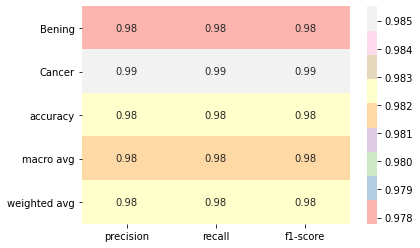

In [63]:
target_names = ['Bening', 'Cancer'] 
clf_report = classification_report(yte, y_pred_model_lr_3, target_names=target_names, output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap = 'Pastel1')

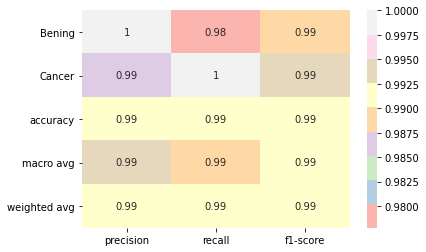

In [64]:
clf_report = classification_report(yte, y_pred_model_svm_3, target_names=target_names, output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap = 'Pastel1')